# Generating Figure 3

## Imports and Variables

In [858]:
from align_spheroid import CellSimulator, Aligner2D
from align_spheroid.evaluation import (
    compare_paths, procrustes_distance, hausdorff_distance, earth_movers_distance, 
    frechet_distance, relative_movement, normalize_distance, distance_matrix_error,
    alignment_accuracy, build_long_true, calc_accuracy
)
from align_spheroid.alignment import convert_raw_to_long
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.patheffects as path_effects
from matplotlib import colors as mplc
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial.distance import pdist, cdist
from scipy.linalg import svd
from tqdm.auto import tqdm
import itertools
from itertools import chain, repeat
from IPython.core.display import HTML
from sklearn.preprocessing import MinMaxScaler
import string
import re
import os

In [254]:
# set variables
out_dir = "output"

# Time points (excluding the last one)
timepoints = ["0h", "24h", "48h", "72h", "168h"]

# Marker colors for plotting
marker_color = ['blue', 'orange', 'green', 'red', 'purple']

# Marker shapes
marker_shape = ['o', '^', 's', 'd', '*'] 

# figure dimensions in inches
fig_width = 6.5
fig_height = 8

# figure parameters
title_fs = 12
annot_fs = 8
label_fs = 10
tick_fs = 8

# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

## Data Prep

In [4]:
# Load data from Excel file
a3_data = pd.read_csv('a3_coordinates_alltimepoints.csv')
a3_data = a3_data[a3_data.columns.drop(list(a3_data.filter(regex='336')))]

dataX = a3_data[[col for col in a3_data.columns if 'X' in col]].values 
dataY = a3_data[[col for col in a3_data.columns if 'Y' in col]].values 

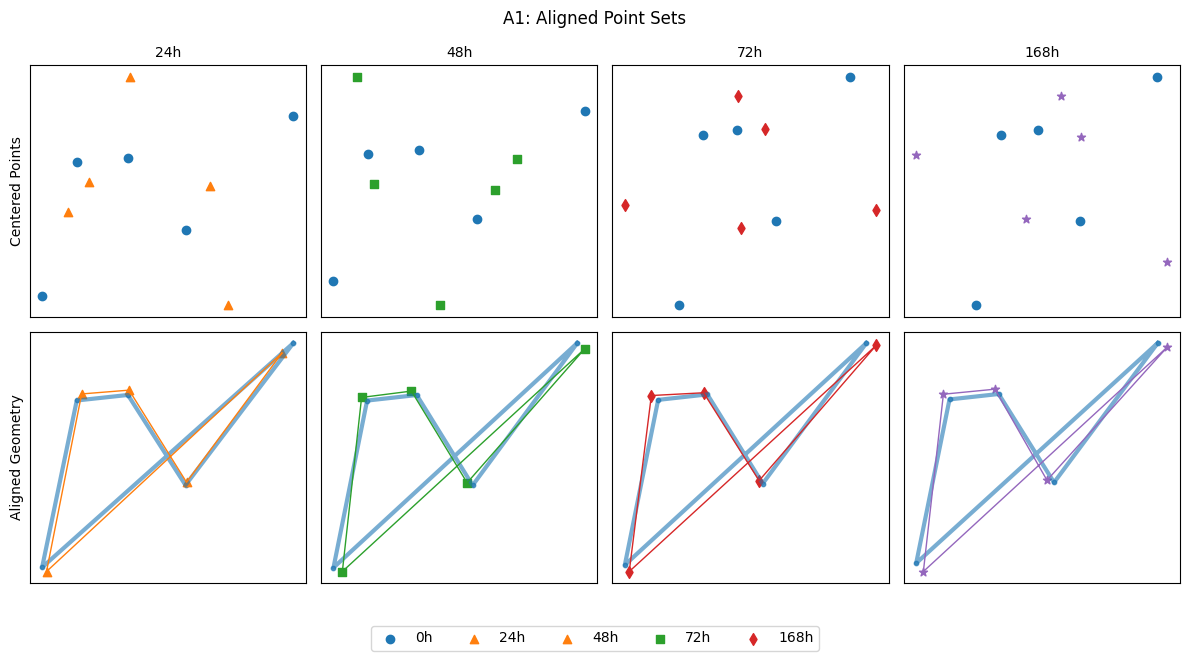

<Figure size 640x480 with 0 Axes>

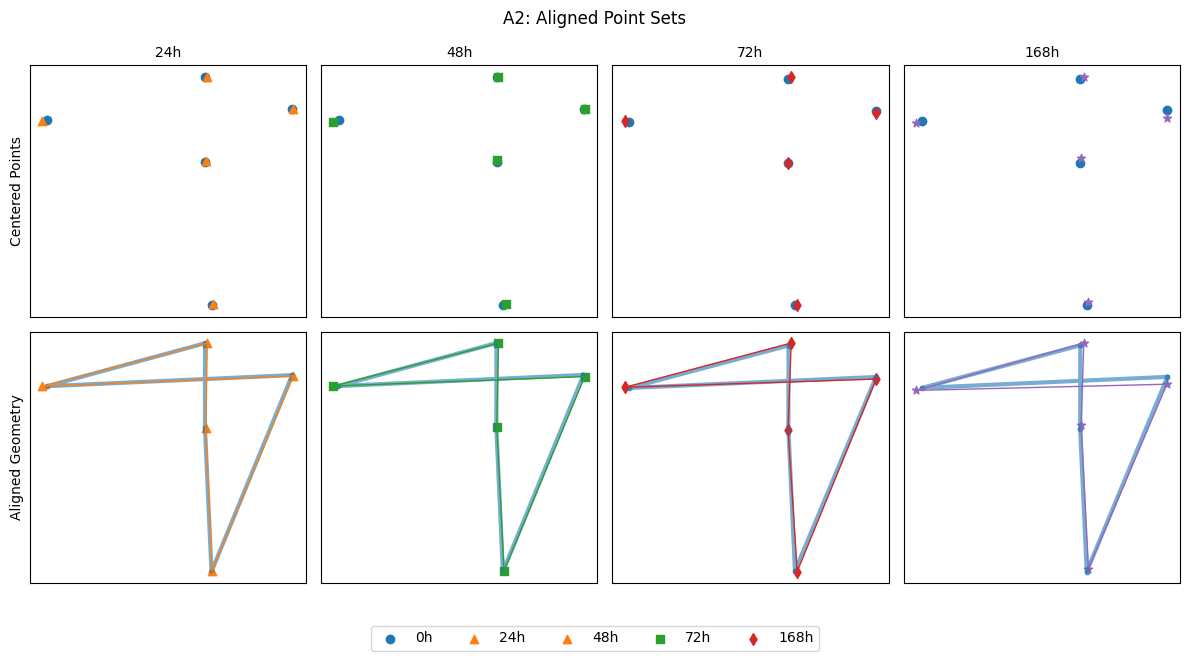

<Figure size 640x480 with 0 Axes>

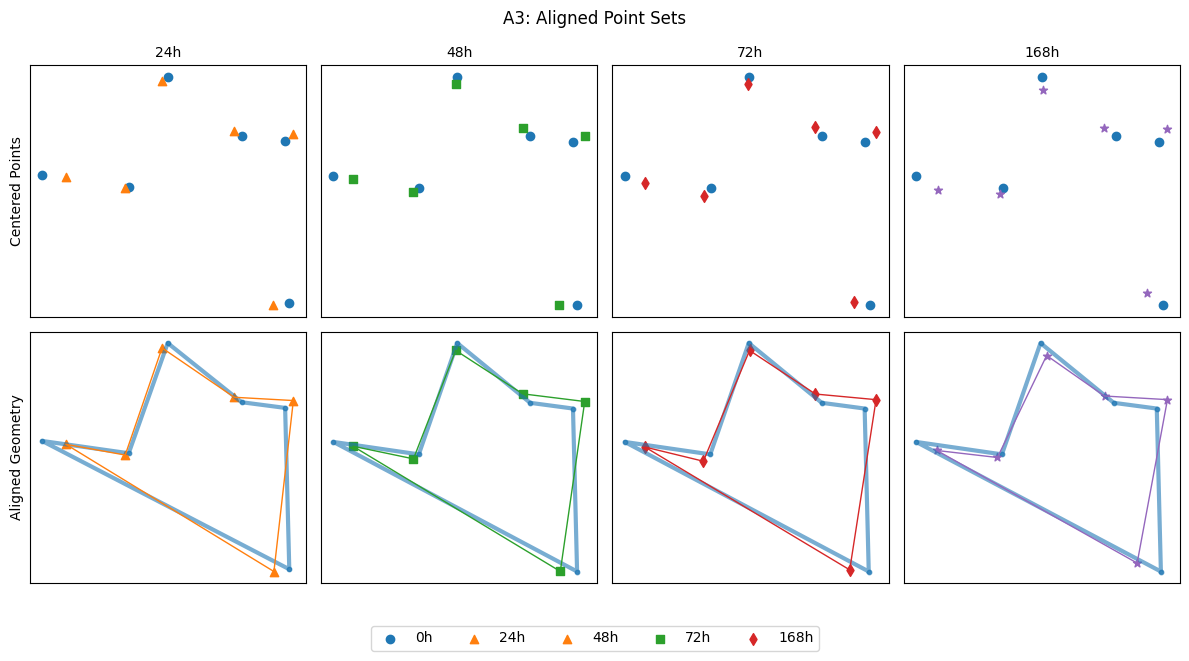

<Figure size 640x480 with 0 Axes>

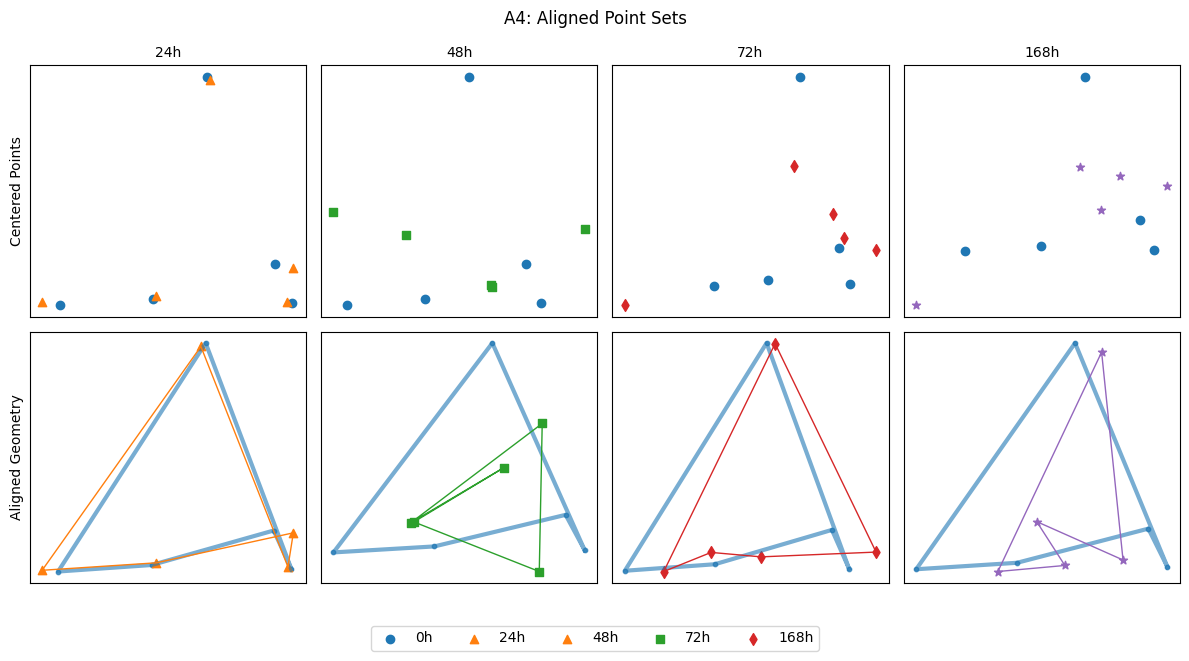

<Figure size 640x480 with 0 Axes>

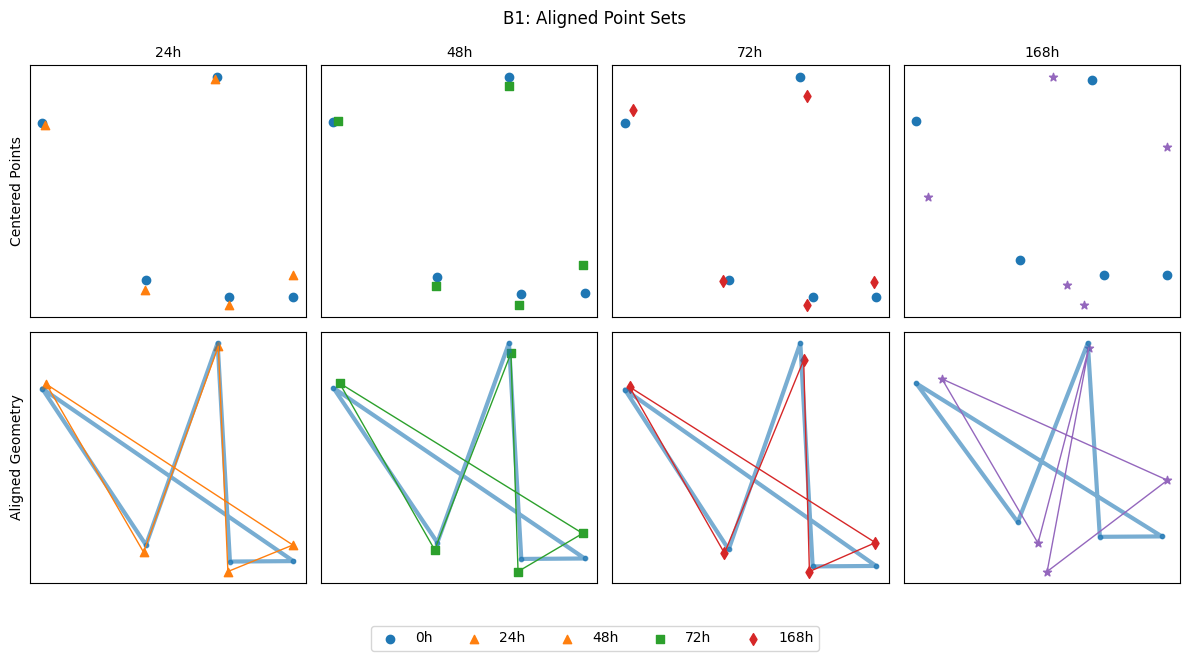

<Figure size 640x480 with 0 Axes>

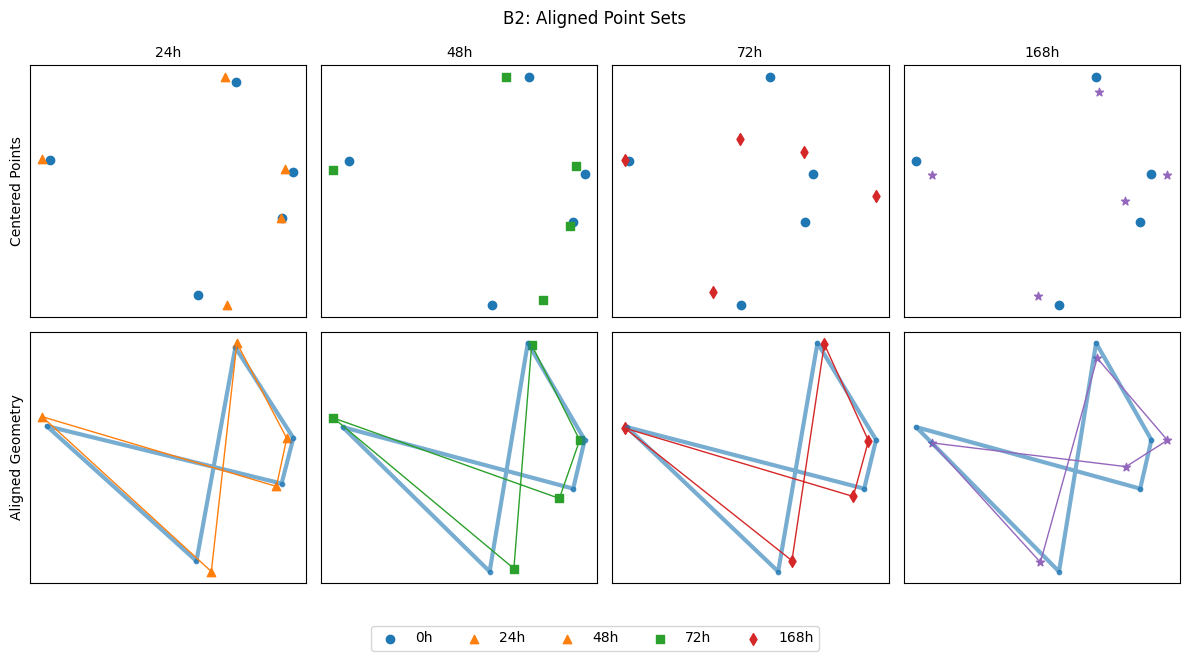

<Figure size 640x480 with 0 Axes>

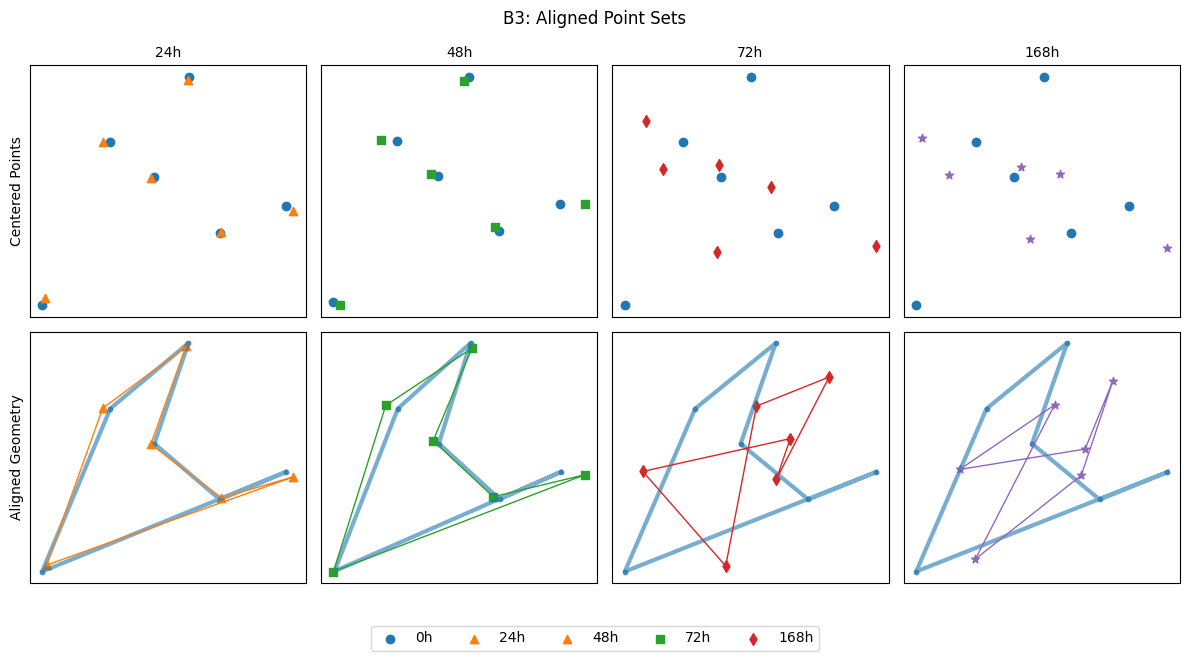

<Figure size 640x480 with 0 Axes>

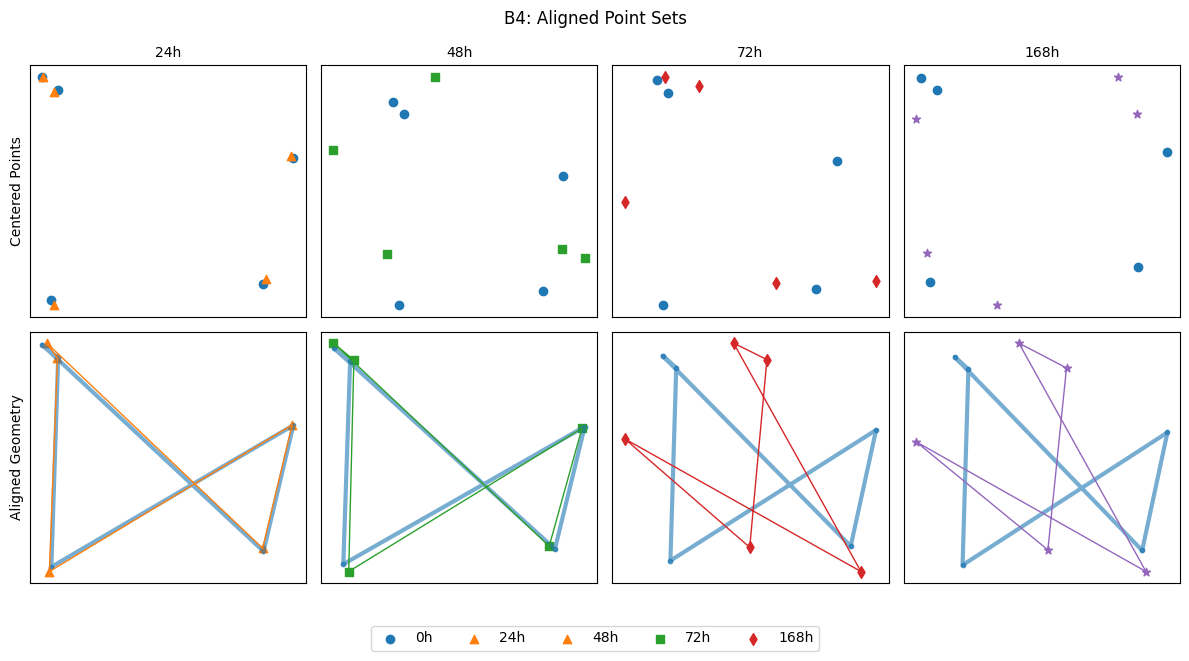

<Figure size 640x480 with 0 Axes>

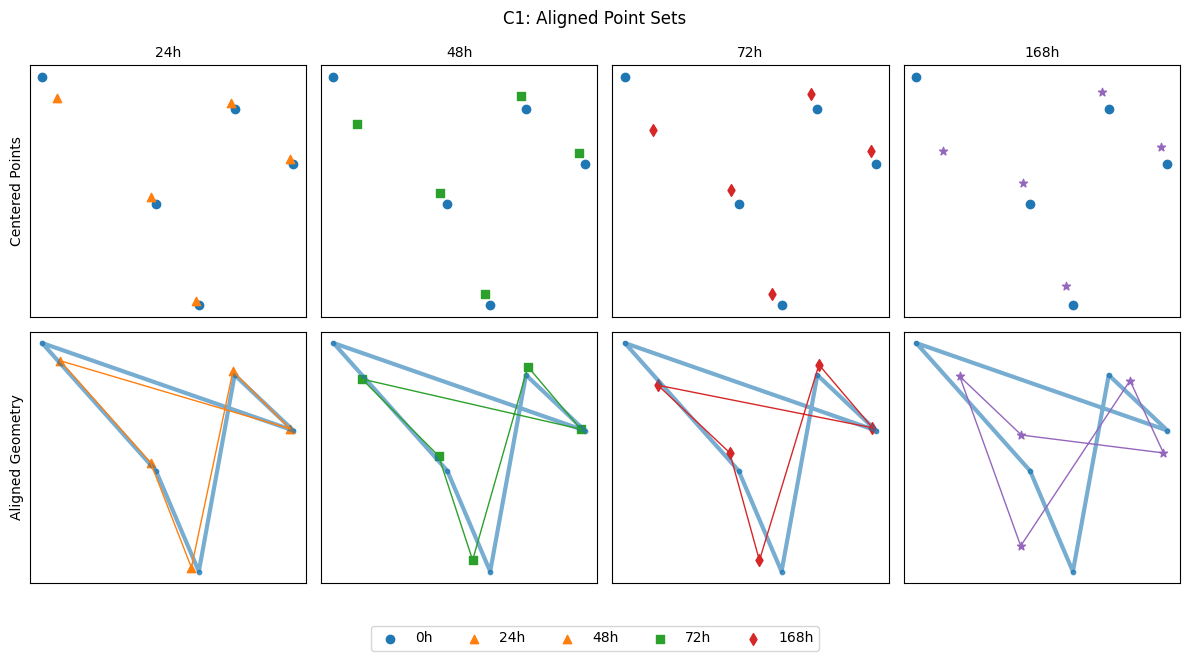

<Figure size 640x480 with 0 Axes>

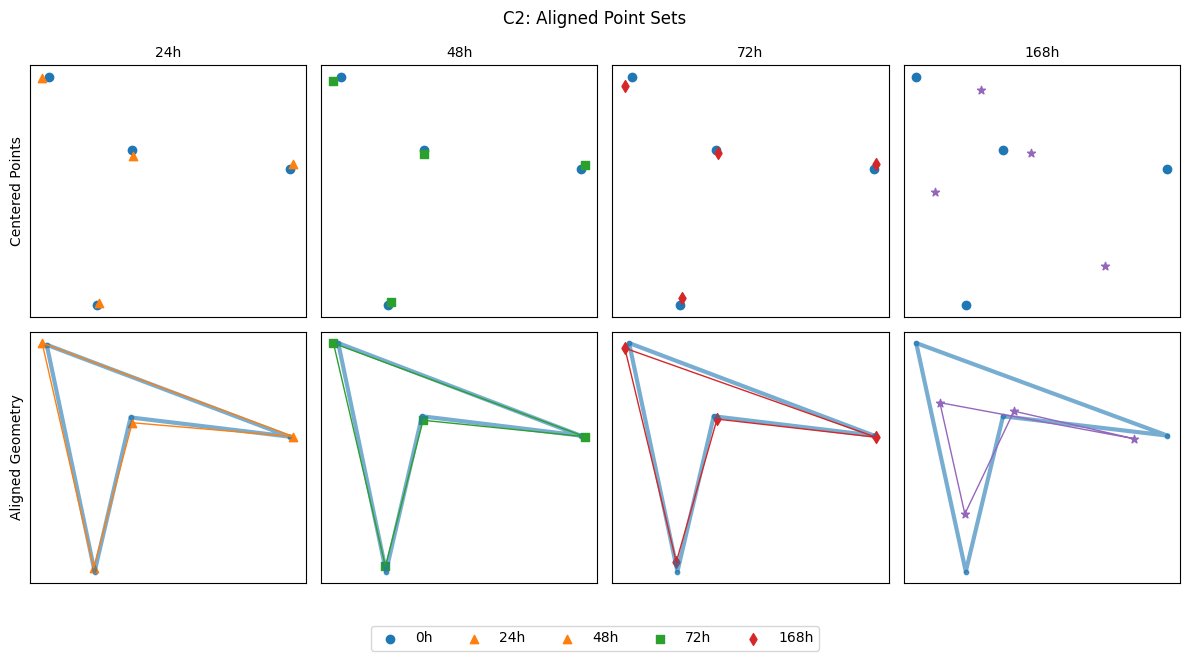

<Figure size 640x480 with 0 Axes>

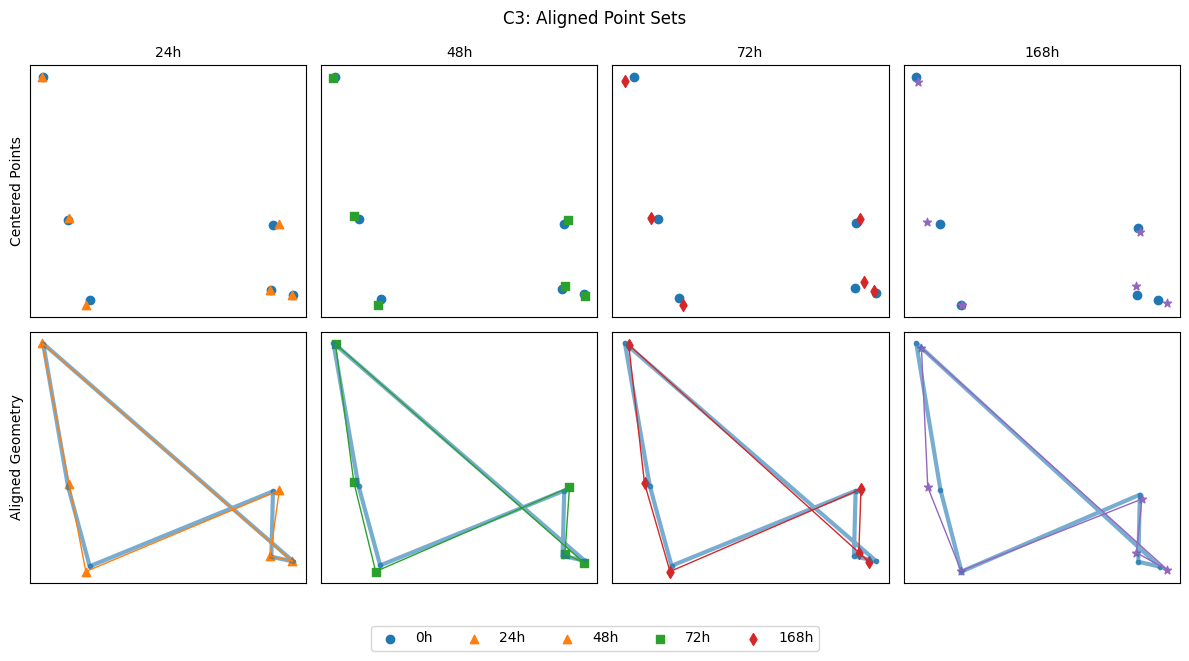

<Figure size 640x480 with 0 Axes>

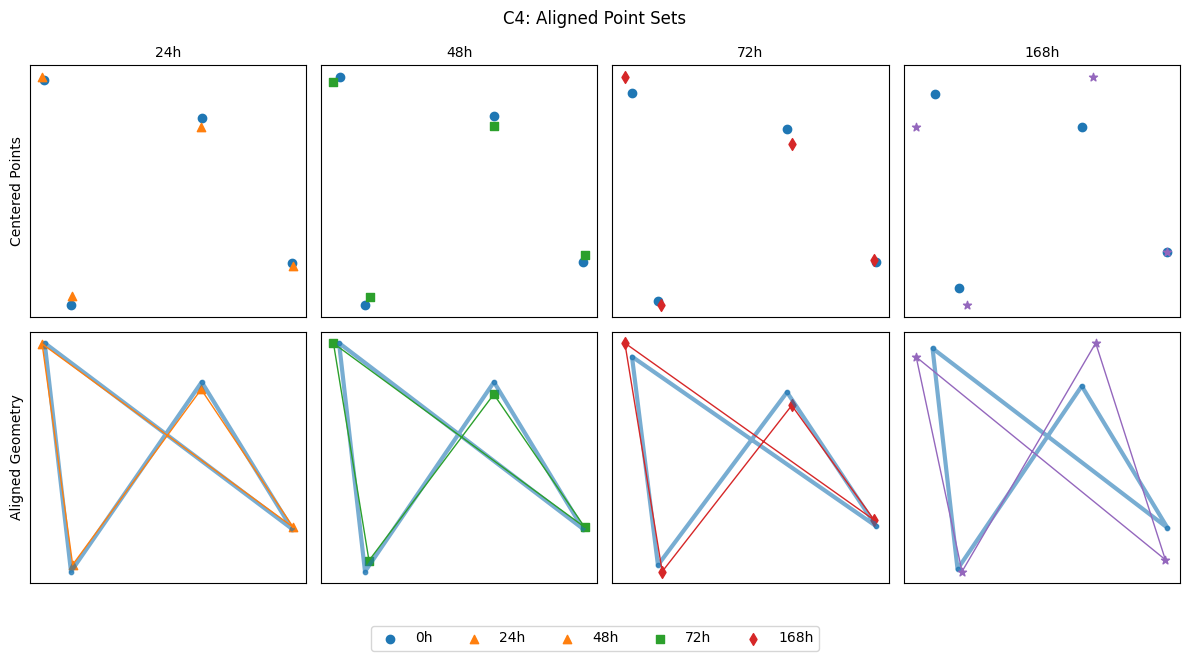

<Figure size 640x480 with 0 Axes>

In [151]:
# find range for each well 
well_ranges = {
    'A1': ([-4 * 10 ** 4, -2 * 10 ** 4], [ 2 * 10 ** 4, 4 * 10 ** 4]),
    'A2': ([-4*10**4, -2*10**4], [0*10**4, 2*10**4]),
    'A3': ([-4*10**4, -2*10**4], [-2*10**4, 0*10**4]),
    'A4': ([-4*10**4, -2*10**4], [-4*10**4, -2*10**4]),
    'B1': ([-2*10**4, 0*10**4], [2*10**4, 3.5*10**4]),
    'B2': ([-2*10**4, 0*10**4], [0*10**4, 2*10**4]),
    'B3': ([-2*10**4, 0*10**4], [-2*10**4, 0*10**4]),
    'B4': ([-2*10**4, 0*10**4], [-4*10**4, -2*10**4]),
    'C1': ([0*10**4, 2*10**4], [1.5*10**4, 3.5*10**4]),
    'C2': ([0*10**4, 2*10**4], [0*10**4, 2*10**4]),
    'C3': ([0*10**4, 2*10**4], [-2*10**4, 0*10**4]),
    'C4': ([0*10**4, 2*10**4], [-4*10**4, -2*10**4])
}
wells = list(well_ranges.keys())

aligners = {}

for well in wells:
    x_range = well_ranges[well][0]
    y_range = well_ranges[well][1]
    
    # Find indices of organoids in well
    well_id = np.where((dataX[:, 0] >= x_range[0]) & (dataX[:, 0] < x_range[1]) &
                        (dataY[:, 0] >= y_range[0]) & (dataY[:, 0] < y_range[1]))[0]

    well_x = dataX[well_id, :]
    well_y = dataY[well_id, :]
    
    # Create an Aligner2D instance
    aligner = Aligner2D(well_name=well, time_points=timepoints)

    # get the labels to use for the alignment
    labels = list(a3_data['Point Name'][well_id])

    # Align the data (well_id 0 is just an example)
    aligner = aligner.align(well_x, well_y)#, labels_0=labels)
    aligners[well] = aligner

    # plotting
    fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
    aligner.plot(fig=fig, axs=axs, show_plot=True, save=True, save_dir="supplementary_figures")  # Pass fig and axs
    plt.tight_layout()
    plt.show()
    plt.close()

In [152]:
well_distances = {}
for well in wells:
    p1 = aligners[well].aligned_points[0]
    distances = []
    for pa in aligners[well].aligned_points[1:]:
        distances.append(normalize_distance(p1, frechet_distance(p1, pa)))
    well_distances[well] = distances
well_distances_df = pd.DataFrame(well_distances)
well_distances_df['timepoint'] = timepoints[1:]

In [153]:
well_distances_df_long = well_distances_df.melt(id_vars='timepoint')
well_distances_df_long.columns = ['Timepoint', 'Well', 'Normalized Frechet']

In [154]:
well_spheroid_mapping = {
    'A1': ['60', '61', '62', '63', '64'],
    'A2': ['44', '45', '46', '47', '48'],
    'A3': ['29', '30', '31', '32', '33', '34'],
    'A4': ['12', '13', '14', '15', '16'],
    'B1': ['54', '55', '56', '57', '59'],
    'B2': ['39', '40', '41', '42', '43'],
    'B3': ['23', '24', '25', '26', '27', '28'],
    'B4': ['07', '08', '09', '10', '11'],
    'C1': ['49', '50', '51', '52', '53'],
    'C2': ['35', '36', '37', '38'],
    'C3': ['17', '18', '19', '20', '21', '22'],
    'C4': ['01', '04', '05', '06']
}
# stable = 0
# aligned = 1
# unaligned = 2
measurement_data = pd.DataFrame({
    "Well": wells,
    "24h": [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
    "48h": [1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0],
    "72h": [1, 0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1],
    "168h": [1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1]
})

## Figure

/Users/cramere/miniconda3/envs/tem-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/Users/cramere/miniconda3/envs/tem-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


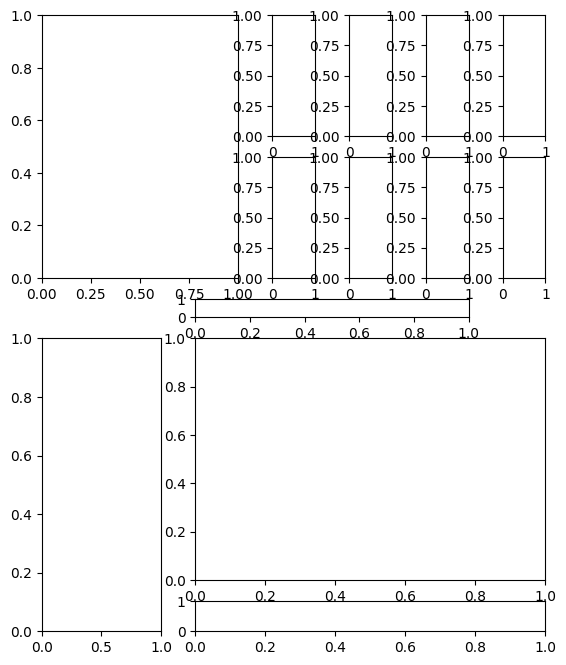

In [859]:
fig = plt.figure(layout='constrained', figsize=(fig_width, fig_height))
axd = fig.subplot_mosaic(
    """
    AAA0123
    AAA4567
    ..llll.
    CCDDDDD
    CCddddd
    """,
    # set the height ratios between the rows
    height_ratios=[1, 1, 0.15, 2, 0.25],
    # set the width ratios between the columns
    #width_ratios=[1, 1, 1, 1, 2.5, 2.5, 2.5, 2.5],
    gridspec_kw={'wspace': 0.8, 'hspace': 0.2}
)
#identify_axes(axd)

In [860]:
## Panel 3A
# timepoints
# load the position data for the A3 well plate
a3_wellplate = pd.read_csv('a3_coordinates_alltimepoints.csv')

# Extract X and Y coordinates
dataX = a3_wellplate.iloc[0:, list(np.arange(1,a3_wellplate.shape[1], 3))].values # ignore the headers
dataY = a3_wellplate.iloc[0:, list(np.arange(2,a3_wellplate.shape[1], 3))].values

ax = axd['A']

# Plot all organoids
for i in range(len(timepoints)):
    ax.scatter(dataX[:, i], dataY[:, i], c = sns.color_palette('tab10')[i], marker=marker_shape[i], alpha=0.5, s=5)

ax.set_title('Well Plate', fontsize=label_fs)
ax.set_xlim(left = -40000, right = 20000)
ax.set_xticks([-30000, -10000, 10000], labels = ["A", "B", "C"], fontsize=tick_fs)
ax.set_yticks(ticks = [-30000, -10000, 8000, 28000], labels = [4, 3, 2, 1], fontsize=tick_fs)

# adding "wells" to the plot
ax.add_patch(plt.Circle((-29000, 28000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-29000, 8000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-29000, -12000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-29000, -32000), 9000, ec = 'blue', fill=False))

ax.add_patch(plt.Circle((-10000, 28000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-10000, 8000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-10000, -12000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-10000, -32000), 9000, ec = 'blue', fill=False))

ax.add_patch(plt.Circle((10000, 28000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((10000, 8000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((10000, -12000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((10000, -32000), 9000, ec = 'blue', fill=False))

ax.axis('equal')

/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_98761/3477719508.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(dataX[:, i], dataY[:, i], c = sns.color_palette('tab10')[i], marker=marker_shape[i], alpha=0.5, s=5)


(-40850.0, 21850.0, -44900.0, 40900.0)

In [861]:
ax = axd['l']
# make a plot with a separate legend for the marker shapes
num_markers = len(marker_shape)
x = np.arange(1, num_markers + 1)
y = np.zeros(num_markers)
for i, marker in enumerate(marker_shape):
    ax.plot(x[i], y[i], marker=marker, markersize=5, label=f"'{timepoints[i]}'")
    ax.text(x[i]+0.25, y[i]-0.003, timepoints[i], fontsize=annot_fs)
ax.axis('off')
#plt.tight_layout()

(0.8, 5.2, -0.05500000000000001, 0.05500000000000001)

In [864]:
# Figure 3B
axs = [axd[str(k)] for k in range(4)]

wells_in_figure = ['A1', 'B1', 'B4', 'C1']

point_size = 3

for i, well in enumerate(wells_in_figure):
    al = aligners[well]
    plot_df = al.registered_df
    scaler = MinMaxScaler()
    for t, tp in enumerate(timepoints):
        raw_x = plot_df['raw_x'][plot_df['timepoint'] == tp]
        raw_x = scaler.fit_transform(raw_x.to_numpy())
        raw_y = plot_df['raw_y'][plot_df['timepoint'] == tp]
        raw_y = scaler.fit_transform(raw_y.to_numpy())
        axs[i].plot(raw_x, raw_y, marker_shape[t], label=f'{timepoints[t]}', alpha=0.8, markersize=point_size)
        axs[i].set_title(f"{well}", fontsize=label_fs)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].axis('equal')
        axs[i].set_aspect('equal', adjustable='box')
axs[0].set_ylabel('Before', fontsize=label_fs)

axs = [axd[str(k)] for k in range(4, 8)]
for i, well in enumerate(wells_in_figure):
    al = aligners[well]
    plot_df = al.registered_df
    for t, tp in enumerate(timepoints):
        reg_x = plot_df['registered_x'][plot_df['timepoint'] == tp]
        reg_y = plot_df['registered_y'][plot_df['timepoint'] == tp]
        axs[i].plot(reg_x, reg_y, marker_shape[t], label=f'{timepoints[t]}', alpha=0.8, markersize=point_size)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].axis('equal')
        axs[i].set_aspect('equal', adjustable='box')
axs[0].set_ylabel('After', fontsize=label_fs)

ValueError: Expected 2D array, got 1D array instead:
array=[-23474.7 -26802.3 -28579.4 -30157.7 -31226.6].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [863]:
# data for panel c
f3c_df = pd.merge(
    well_distances_df_long, 
    measurement_data.melt(id_vars='Well', var_name='Timepoint', value_name='Status'), 
    on=['Well', 'Timepoint']
)
f3c_df = f3c_df.drop(['Timepoint'], axis=1)
f3c_df=f3c_df.mask(f3c_df==0).fillna(1)
f3c_df=f3c_df.mask(f3c_df==2).fillna(0)

In [850]:
ax = axd['C']
point_size=10
sns.scatterplot(
    data = f3c_df,
    y = 'Status',
    x = 'Normalized Frechet',
    hue = 'Well',
    #marker= 'Timepoint',
    s=point_size,
    alpha=0.8,
    #palette=sns.palettes.color_palette('Set1'),
    style='Well',
    ax=ax
)
ax.set_title('Matching Success', fontsize=label_fs)
ax.set_ylabel("")
ax.set_xlabel('Normalized\n Frechét Distance', fontsize=label_fs)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Fail", "Success"], fontsize=tick_fs, rotation=90)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(np.arange(11), fontsize=tick_fs)
ax.legend(ncol=2, fontsize=annot_fs, title='Well', title_fontsize=annot_fs, 
          loc='upper right', handletextpad=0.1, columnspacing=-0.7, markerscale=2)
handles3c, labels3c = ax.get_legend_handles_labels()

#ax.get_legend().remove()

# add the legend to the axis below
#ax_leg = axd['c']
#ax_leg.legend(handles, labels, ncol=2, fontsize=annot_fs-2, title='Well', title_fontsize=annot_fs, loc='lower center', frameon=False)
#ax_leg.axis('off')

In [851]:
# data for panel D
spheroid_rotation_df = pd.DataFrame({
    'Well':[item for sublist in [[k]*len(i) for k, i in well_spheroid_mapping.items()] for item in sublist],
    'Spheroid':[item for sublist in [i for k, i in well_spheroid_mapping.items()] for item in sublist]
})
f3d_df = pd.merge(spheroid_rotation_df, measurement_data, how='left', on='Well')

In [852]:
ax = axd['D']
# colorblind friendly palette
pal = sns.color_palette('colorblind')
colors = [pal[0], pal[2], pal[6]]  # Assign colors to measurement types
#colors = ['#B0C8E0','#A6D0A6', '#F2A0B0']
cmap = sns.color_palette(colors)
patterns = ['o', '/', 'X']
spheroid_list = list(f3d_df['Spheroid'])
hatch_color = 'black'
edge_color = 'white'

# Plotting
plot_df = f3d_df[['24h', '48h', '72h', '168h']].T
sns.heatmap(
    data=plot_df,
    cmap=colors,
    cbar=False,
    linewidths=0.05,
    linecolor=edge_color,
    edgecolor=edge_color,
    ax=ax
)

# Iterate through cells and apply hatches

for i in range(plot_df.shape[0]):
    for j in range(plot_df.shape[1]):
        if plot_df.iloc[i, j] == 0:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch=patterns[0], 
                                       facecolor=hatch_color, edgecolor=hatch_color, linewidth=0))
        if plot_df.iloc[i, j] == 1:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch=patterns[1], 
                                       facecolor=hatch_color, edgecolor=hatch_color, linewidth=0))
        if plot_df.iloc[i, j] == 2:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch=patterns[2], 
                                       facecolor=hatch_color, edgecolor=hatch_color, linewidth=0))

# adding well plate annotations
trans = ax.get_xaxis_transform()
y_off = -0.1
ax.annotate('Well', xy=(-1.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([0.25,4.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A1', xy=(2.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([5.25,9.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A2', xy=(7.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([10.25,15.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A3', xy=(13.25, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([16.25,20.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A4', xy=(18.75, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([21.25,25.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B1', xy=(23.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([26.25,30.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B2', xy=(28.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([31.25,36.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B3', xy=(34, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([37.25,41.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B4', xy=(39.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([42.25,46.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C1', xy=(45.0, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([47.25,50.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C2', xy=(49.25, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([51.25,56.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C3', xy=(54.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([57.25,60.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C4', xy=(59.25, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)

# create the legend
legend_elements = [
    patches.Patch(facecolor=colors[0], edgecolor=hatch_color, hatch=patterns[0], label='Static'),
    patches.Patch(facecolor=colors[1], edgecolor=hatch_color, hatch=patterns[1], label='Matched'),
    patches.Patch(facecolor=colors[2], edgecolor=hatch_color, hatch=patterns[2], label='Unmatched')
]
# add the legend to the axis below
ax_leg = axd['d']
leg = ax_leg.legend(ncol=3, handles=legend_elements, loc='lower center', 
                fontsize=annot_fs, frameon=False, bbox_to_anchor=(0.6, -1.6))#, handletextpad=0.5, columnspacing=10)
ax_leg.axis('off')

for patch in leg.get_patches():
    patch.set_height(20)
    patch.set_width(20)

#for txt in leg.get_texts():
#    txt.set_ha("center") # horizontal alignment of text item
#    txt.set_x(80) # x-position
#    txt.set_y(40) # y-position

ax.invert_yaxis()
ax.set_xlabel('Spheroid', fontsize=label_fs)
ax.xaxis.labelpad = 20
#ax.minorticks_on()
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
minor_ticks = [i + 0.5 for i in range(len(spheroid_list))]
#ax.tick_params(axis='x', labelsize=tick_fs-4)
#ax.set_xticks(list(range(len(spheroid_list))))
ax.set_xticks(minor_ticks, spheroid_list, minor=True, fontsize=label_fs-4)
#ax.set_xticklabels(spheroid_list)
#ax.set_ylabel('Time Point', fontsize=label_fs)
ax.tick_params(axis='y', labelsize=tick_fs)
ax.set_yticklabels(timepoints[1:])

/Users/cramere/miniconda3/envs/tem-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.draw()


[Text(0, 0.5, '24h'),
 Text(0, 1.5, '48h'),
 Text(0, 2.5, '72h'),
 Text(0, 3.5, '168h')]

/Users/cramere/miniconda3/envs/tem-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


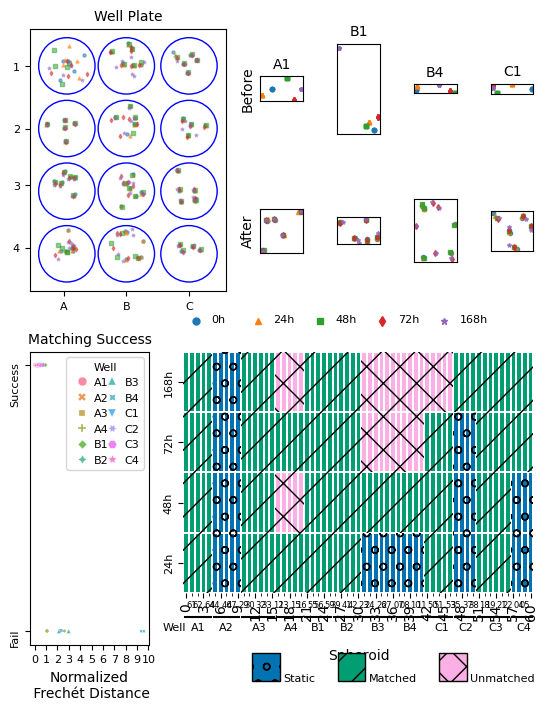

In [853]:
fig

In [826]:
fig.savefig('output/figure_3.png', dpi=300, bbox_inches='tight')

/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_98761/3206325805.py:1: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig('output/figure_3.png', dpi=300, bbox_inches='tight')


## Version 2

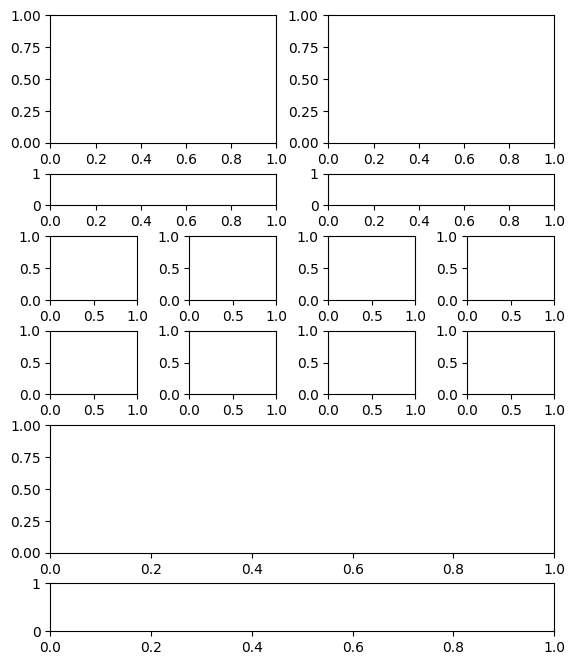

In [578]:
fig = plt.figure(layout='constrained', figsize=(fig_width, fig_height))
axd = fig.subplot_mosaic(
    """
    AACC
    llcc
    0123
    4567
    DDDD
    dddd
    """,
    # set the height ratios between the rows
    height_ratios=[2, 0.5, 1, 1, 2, 0.75],
    # set the width ratios between the columns
    width_ratios=[1, 1, 1, 1, ],
    gridspec_kw={'wspace': 0.6, 'hspace': 0.4}
)

In [565]:
## Panel 3A
# timepoints
# load the position data for the A3 well plate
a3_wellplate = pd.read_csv('a3_coordinates_alltimepoints.csv')

# Extract X and Y coordinates
dataX = a3_wellplate.iloc[0:, list(np.arange(1,a3_wellplate.shape[1], 3))].values # ignore the headers
dataY = a3_wellplate.iloc[0:, list(np.arange(2,a3_wellplate.shape[1], 3))].values

ax = axd['A']

# Plot all organoids
for i in range(len(timepoints)):
    ax.scatter(dataX[:, i], dataY[:, i], c = sns.color_palette('tab10')[i], marker=marker_shape[i], alpha=0.5, s=5)

ax.set_title('Well Plate', fontsize=label_fs)
ax.set_xlim(left = -40000, right = 20000)
ax.set_xticks([-30000, -10000, 10000], labels = ["A", "B", "C"], fontsize=tick_fs)
ax.set_yticks(ticks = [-30000, -10000, 8000, 28000], labels = [4, 3, 2, 1], fontsize=tick_fs)

# adding "wells" to the plot
ax.add_patch(plt.Circle((-29000, 28000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-29000, 8000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-29000, -12000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-29000, -32000), 9000, ec = 'blue', fill=False))

ax.add_patch(plt.Circle((-10000, 28000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-10000, 8000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-10000, -12000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((-10000, -32000), 9000, ec = 'blue', fill=False))

ax.add_patch(plt.Circle((10000, 28000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((10000, 8000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((10000, -12000), 9000, ec = 'blue', fill=False))
ax.add_patch(plt.Circle((10000, -32000), 9000, ec = 'blue', fill=False))

ax.axis('equal')

/var/folders/99/8rc4_4_n7233rmjmy44dmfbs5531hj/T/ipykernel_98761/3477719508.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(dataX[:, i], dataY[:, i], c = sns.color_palette('tab10')[i], marker=marker_shape[i], alpha=0.5, s=5)


(-40850.0, 21850.0, -44900.0, 40900.0)

In [566]:
ax = axd['l']
# make a plot with a separate legend for the marker shapes
num_markers = len(marker_shape)
x = np.arange(1, num_markers + 1)
y = np.zeros(num_markers)
for i, marker in enumerate(marker_shape):
    ax.plot(x[i], y[i], marker=marker, markersize=5, label=f"'{timepoints[i]}'")
    ax.text(x[i]+0.25, y[i]-0.003, timepoints[i], fontsize=annot_fs)
ax.axis('off')
#plt.tight_layout()

(0.8, 5.2, -0.05500000000000001, 0.05500000000000001)

In [567]:
# Figure 3B
axs = [axd[str(k)] for k in range(4)]

wells_in_figure = ['A1', 'B1', 'B4', 'C1']

point_size = 3

for i, well in enumerate(wells_in_figure):
    al = aligners[well]
    plot_df = al.registered_df
    for t, tp in enumerate(timepoints):
        raw_x = plot_df['raw_x'][plot_df['timepoint'] == tp]
        raw_y = plot_df['raw_y'][plot_df['timepoint'] == tp]
        axs[i].plot(raw_x, raw_y, marker_shape[t], label=f'{timepoints[t]}', alpha=0.8, markersize=point_size)
        axs[i].set_title(f"{well}", fontsize=label_fs)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].axis('equal')
axs[0].set_ylabel('Before', fontsize=label_fs)

axs = [axd[str(k)] for k in range(4, 8)]
for i, well in enumerate(wells_in_figure):
    al = aligners[well]
    plot_df = al.registered_df
    for t, tp in enumerate(timepoints):
        reg_x = plot_df['registered_x'][plot_df['timepoint'] == tp]
        reg_y = plot_df['registered_y'][plot_df['timepoint'] == tp]
        axs[i].plot(reg_x, reg_y, marker_shape[t], label=f'{timepoints[t]}', alpha=0.8, markersize=point_size)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].axis('equal')
axs[0].set_ylabel('After', fontsize=label_fs)

Text(102.74999999999999, 0.5, 'After')

In [568]:
# data for panel c
f3c_df = pd.merge(
    well_distances_df_long, 
    measurement_data.melt(id_vars='Well', var_name='Timepoint', value_name='Status'), 
    on=['Well', 'Timepoint']
)
f3c_df = f3c_df.drop(['Timepoint'], axis=1)
f3c_df=f3c_df.mask(f3c_df==0).fillna(1)
f3c_df=f3c_df.mask(f3c_df==2).fillna(0)

In [569]:
ax = axd['C']
sns.scatterplot(
    data = f3c_df,
    y = 'Status',
    x = 'Normalized Frechet',
    hue = 'Well',
    #marker= 'Timepoint',
    s=25,
    alpha=0.8,
    #palette=sns.palettes.color_palette('Set1'),
    style='Well',
    ax=ax
)
ax.set_ylabel('Matching Success', fontsize=label_fs)
ax.set_xlabel('Normalized Frechét Distance', fontsize=label_fs)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Fail", "Success"], fontsize=tick_fs, rotation=90)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(np.arange(11), fontsize=tick_fs)
ax.legend(ncol=3, fontsize=annot_fs, title='Well', title_fontsize=annot_fs, loc='best')
handles, labels = ax.get_legend_handles_labels()

#ax.get_legend().remove()

# add the legend to the axis below
#ax_leg = axd['c']
#ax_leg.legend(handles, labels, ncol=2, fontsize=annot_fs-2, title='Well', title_fontsize=annot_fs, loc='lower center', frameon=False)
#ax_leg.axis('off')

In [570]:
# data for panel D
spheroid_rotation_df = pd.DataFrame({
    'Well':[item for sublist in [[k]*len(i) for k, i in well_spheroid_mapping.items()] for item in sublist],
    'Spheroid':[item for sublist in [i for k, i in well_spheroid_mapping.items()] for item in sublist]
})
f3d_df = pd.merge(spheroid_rotation_df, measurement_data, how='left', on='Well')

In [571]:
ax = axd['D']
# colorblind friendly palette
pal = sns.color_palette('colorblind')
colors = [pal[0], pal[2], pal[6]]  # Assign colors to measurement types
#colors = ['#B0C8E0','#A6D0A6', '#F2A0B0']
cmap = sns.color_palette(colors)
patterns = ['o', '/', 'X']
spheroid_list = list(f3d_df['Spheroid'])
hatch_color = 'black'
edge_color = 'white'

# Plotting
plot_df = f3d_df[['24h', '48h', '72h', '168h']].T
sns.heatmap(
    data=plot_df,
    cmap=colors,
    cbar=False,
    linewidths=0.05,
    linecolor=edge_color,
    edgecolor=edge_color,
    ax=ax
)

# Iterate through cells and apply hatches

for i in range(plot_df.shape[0]):
    for j in range(plot_df.shape[1]):
        if plot_df.iloc[i, j] == 0:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch=patterns[0], 
                                       facecolor=hatch_color, edgecolor=hatch_color, linewidth=0))
        if plot_df.iloc[i, j] == 1:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch=patterns[1], 
                                       facecolor=hatch_color, edgecolor=hatch_color, linewidth=0))
        if plot_df.iloc[i, j] == 2:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch=patterns[2], 
                                       facecolor=hatch_color, edgecolor=hatch_color, linewidth=0))

# adding well plate annotations
trans = ax.get_xaxis_transform()
y_off = -0.1
ax.annotate('Well', xy=(-1.0, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([0.25,4.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A1', xy=(2.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([5.25,9.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A2', xy=(7.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([10.25,15.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A3', xy=(13.25, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([16.25,20.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('A4', xy=(18.75, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([21.25,25.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B1', xy=(23.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([26.25,30.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B2', xy=(28.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([31.25,36.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B3', xy=(34, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([37.25,41.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('B4', xy=(39.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([42.25,46.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C1', xy=(45.0, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([47.25,50.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C2', xy=(49.25, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([51.25,56.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C3', xy=(54.5, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)
ax.plot([57.25,60.75],[y_off, y_off], color="k", transform=trans, clip_on=False)
ax.annotate('C4', xy=(59.25, y_off-.02), xycoords=trans, ha="center", va="top", fontsize=annot_fs)

# create the legend
legend_elements = [
    patches.Patch(facecolor=colors[0], edgecolor=hatch_color, hatch=patterns[0], label='Static'),
    patches.Patch(facecolor=colors[1], edgecolor=hatch_color, hatch=patterns[1], label='Matched'),
    patches.Patch(facecolor=colors[2], edgecolor=hatch_color, hatch=patterns[2], label='Unmatched')
]
# add the legend to the axis below
ax_leg = axd['d']
leg = ax_leg.legend(ncol=3, handles=legend_elements, loc='center', 
                fontsize=annot_fs, bbox_to_anchor=(0.3, -0.3, 0.5, 0.5),
                frameon=False)#, handletextpad=0.5, columnspacing=10)
ax_leg.axis('off')

for patch in leg.get_patches():
    patch.set_height(10)
    #patch.set_width(0)

#for txt in leg.get_texts():
#    txt.set_ha("center") # horizontal alignment of text item
#    txt.set_x(80) # x-position
#    txt.set_y(40) # y-position

ax.invert_yaxis()
ax.set_xlabel('Spheroid', fontsize=label_fs)
ax.xaxis.labelpad = 15
ax.tick_params(axis='x', labelsize=tick_fs-4)
ax.set_xticks(list(range(len(spheroid_list))))
ax.set_xticklabels(spheroid_list)
ax.set_ylabel('Time Point', fontsize=label_fs)
ax.tick_params(axis='y', labelsize=tick_fs)
ax.set_yticklabels(timepoints[1:])
#plt.margins(x=0.02, y=0.05)

/Users/cramere/miniconda3/envs/tem-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.draw()


[Text(0, 0.5, '24h'),
 Text(0, 1.5, '48h'),
 Text(0, 2.5, '72h'),
 Text(0, 3.5, '168h')]

/Users/cramere/miniconda3/envs/tem-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


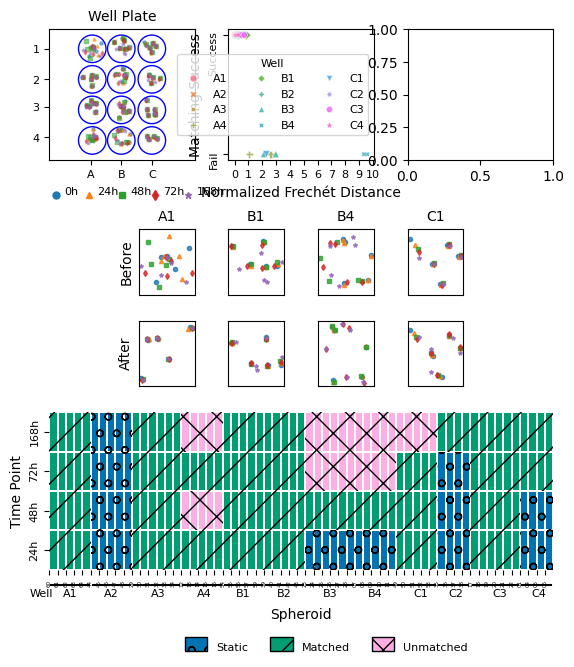

In [572]:
fig